In [ ]:
from multiomicscellsim.cpm.simulation import CPM
from multiomicscellsim.cpm.cpmentities import CPMCellType, CPMGrid
from multiomicscellsim.cpm.constraints import VolumeConstraint, AdhesionConstraint, PerimeterConstraint

Precomputing Neighbors...


  0%|          | 0/150 [00:00<?, ?it/s]/Users/edoardo.giacomello/Projects/Voronoi/multiomicscellsim/cpm/simulation.py:47: RuntimeWarning: overflow encountered in exp
  boltzman_prob = np.exp(-total_delta_energy/self.grid.temperature)
100%|██████████| 150/150 [00:01<00:00, 96.90it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


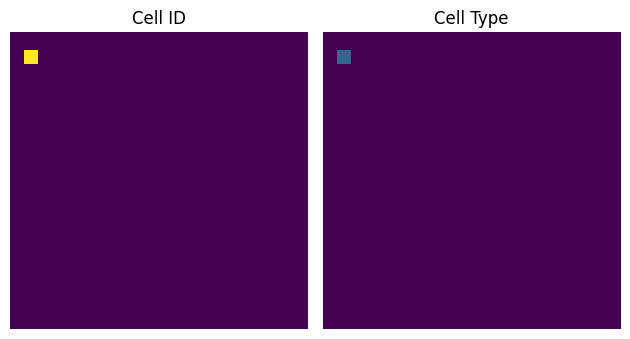

In [ ]:
import math 

n_cell_types = 3
n_initial_cells = 5

# Cell Type definition (WARNING/TODO: LIST MUST BE ORDERED BY ID!)
bka = 15.0 # background adhesion

ciruclar_perimeter = lambda area: int(round(2 * math.sqrt(math.pi * area)))


cell_types = [
    CPMCellType(id=0, adhesion_energy=[15.0, bka, bka, bka], name="background"),
    CPMCellType(id=1, adhesion_energy=[bka, 15.0, 5.0, 5.0], preferred_volume=20, preferred_perimeter=25),
    CPMCellType(id=2, adhesion_energy=[bka, 5.0, 15.0, 5.0], preferred_volume=30, preferred_perimeter=25),
    CPMCellType(id=3, adhesion_energy=[bka, 5.0, 5.0, 15.0], preferred_volume=70, preferred_perimeter=25),
]

grid = CPMGrid(
                        size=64, 
                        temperature=1.0,
                        cell_types=cell_types,
                        constraints=[
                            AdhesionConstraint(), 
                            VolumeConstraint(lambda_volume=10),
                            PerimeterConstraint(lambda_perimeter=1)
                            ]
                     )
cpm = CPM(grid=grid)
grid.spawn_random_cell(n_initial_cells)
#grid.render(0)

from IPython.display import HTML
anim = cpm.render_animation(max_steps=150)
HTML(anim.to_jshtml())

  0%|          | 0/150 [00:00<?, ?it/s]/Users/edoardo.giacomello/Projects/Voronoi/multiomicscellsim/cpm/simulation.py:47: RuntimeWarning: overflow encountered in exp
  boltzman_prob = np.exp(-total_delta_energy/self.grid.temperature)
 15%|█▍        | 22/150 [00:00<00:01, 85.22it/s] 

{'same_id': 41, 'failed': 10, 'passed': 9}
{'same_id': 49, 'failed': 17, 'passed': 11}
{'same_id': 55, 'failed': 20, 'passed': 17}
{'same_id': 76, 'failed': 32, 'passed': 15}
{'same_id': 96, 'failed': 31, 'passed': 18}
{'same_id': 82, 'failed': 26, 'passed': 45}
{'same_id': 132, 'failed': 30, 'passed': 37}
{'same_id': 153, 'failed': 32, 'passed': 44}
{'same_id': 161, 'failed': 42, 'passed': 51}
{'same_id': 173, 'failed': 54, 'passed': 40}
{'same_id': 187, 'failed': 49, 'passed': 41}
{'same_id': 190, 'failed': 47, 'passed': 50}
{'same_id': 181, 'failed': 52, 'passed': 56}
{'same_id': 225, 'failed': 68, 'passed': 57}
{'same_id': 229, 'failed': 57, 'passed': 62}
{'same_id': 252, 'failed': 64, 'passed': 57}
{'same_id': 247, 'failed': 50, 'passed': 62}
{'same_id': 218, 'failed': 67, 'passed': 62}
{'same_id': 256, 'failed': 44, 'passed': 55}
{'same_id': 230, 'failed': 60, 'passed': 54}
{'same_id': 233, 'failed': 74, 'passed': 51}
{'same_id': 231, 'failed': 61, 'passed': 71}


 45%|████▍     | 67/150 [00:00<00:00, 182.08it/s]

{'same_id': 207, 'failed': 60, 'passed': 64}
{'same_id': 190, 'failed': 57, 'passed': 53}
{'same_id': 188, 'failed': 48, 'passed': 34}
{'same_id': 172, 'failed': 28, 'passed': 33}
{'same_id': 143, 'failed': 41, 'passed': 28}
{'same_id': 130, 'failed': 31, 'passed': 26}
{'same_id': 134, 'failed': 25, 'passed': 37}
{'same_id': 130, 'failed': 26, 'passed': 25}
{'same_id': 121, 'failed': 24, 'passed': 22}
{'same_id': 105, 'failed': 29, 'passed': 33}
{'same_id': 92, 'failed': 34, 'passed': 37}
{'same_id': 104, 'failed': 17, 'passed': 22}
{'same_id': 82, 'failed': 19, 'passed': 23}
{'same_id': 84, 'failed': 21, 'passed': 19}
{'same_id': 69, 'failed': 17, 'passed': 15}
{'same_id': 59, 'failed': 18, 'passed': 13}
{'same_id': 49, 'failed': 11, 'passed': 13}
{'same_id': 40, 'failed': 7, 'passed': 8}
{'same_id': 30, 'failed': 4, 'passed': 2}
{'same_id': 19, 'failed': 4, 'passed': 2}
{'same_id': 12, 'failed': 0, 'passed': 1}
{'same_id': 4, 'failed': 0, 'passed': 0}
{'same_id': 3, 'failed': 1, 'pas

100%|██████████| 150/150 [00:00<00:00, 232.87it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, 'failed': 0, 'passed': 0}
{'same_id': 0, '

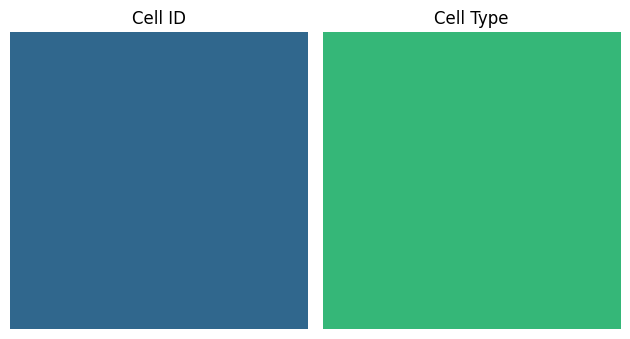

In [6]:
import sys
sys.modules['debugpy'].__file__

'/Users/edoardo.giacomello/Projects/Voronoi/venv/lib/python3.9/site-packages/debugpy/__init__.py'

In [ ]:
from multiomicscellsim.cpm.simulation import CPM
from multiomicscellsim.cpm.cpmentities import CPMCellType, CPMGrid
from multiomicscellsim.cpm.constraints import VolumeConstraint, AdhesionConstraint, PerimeterConstraint

n_cell_types = 3
n_initial_cells = 1

# Cell Type definition (WARNING/TODO: LIST MUST BE ORDERED BY ID!)
bka = 15.0 # background adhesion
cell_types = [
    CPMCellType(id=0, adhesion_energy=[1000.0, bka, bka, bka], name="background"),
    CPMCellType(id=1, adhesion_energy=[bka, 15.0, 5.0, 5.0], preferred_volume=9, preferred_perimeter=32),
    CPMCellType(id=2, adhesion_energy=[bka, 5.0, 15.0, 5.0], preferred_volume=9, preferred_perimeter=32),
    CPMCellType(id=3, adhesion_energy=[bka, 5.0, 5.0, 15.0], preferred_volume=9, preferred_perimeter=32),
]

grid = CPMGrid(
                        size=8, 
                        temperature=1.0,
                        cell_types=cell_types,
                        constraints=[
                            AdhesionConstraint(), 
                            VolumeConstraint(lambda_volume=1.0),
                            #PerimeterConstraint(lambda_perimeter=1.0)
                            ]
                     )
cpm = CPM(grid=grid)
#grid.spawn_random_cell(n_initial_cells)


In [ ]:
grid.draw_cell_at([2, 2], 1)
grid.draw_cell_at([2, 5], 1)
grid.render(plot_layer=0)

In [ ]:
for c in grid._cells:
    print(c.perimeter)

In [ ]:
grid.copy_pixel([3, 4], [3, 3])
for c in grid._cells:
    print(c.perimeter)

In [ ]:
grid.render(plot_layer=0)

In [ ]:
grid._cells[1]._neighbors

In [ ]:
grid._cells[2]._neighbors